1. Setup & Imports

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

2. Load Data

In [28]:
# Load your dataset
df = pd.read_csv("../data/raw_analyst_ratings.csv")

# Explore basic info
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst 5 rows:")
df.head()

Dataset shape: (1407328, 6)

Columns: ['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock']

First 5 rows:


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


Step 3:  Clean the data

In [30]:
# ============================
# CHECK ORIGINAL DATE VALUES
# ============================

import pandas as pd
import numpy as np

# Load original dataset
original_df = pd.read_csv("../data/raw_analyst_ratings.csv")  # change path if needed

# Ensure 'date' column exists
if 'date' not in original_df.columns:
    raise ValueError("Column 'date' not found in original data")

# Sample 100,000 random rows
sample_df = original_df.sample(n=100000, random_state=42)

# Convert to datetime without cleaning to inspect raw hour
sample_df['date_raw'] = pd.to_datetime(sample_df['date'], errors='coerce', utc=True)

# Extract hour
sample_df['hour_raw'] = sample_df['date_raw'].dt.hour

# Count how many are 0
num_zero_hours = (sample_df['hour_raw'] == 0).sum()
total_sampled = len(sample_df)

print(f"Out of {total_sampled:,} sampled rows, {num_zero_hours:,} have hour = 0")

# Display first 20 rows with hour=0
print("\n=== Sample rows with hour=0 ===")
print(sample_df[sample_df['hour_raw'] == 0].head(20)[['date', 'hour_raw']])


Out of 100,000 sampled rows, 95,916 have hour = 0

=== Sample rows with hour=0 ===
                        date  hour_raw
1201723  2013-04-18 00:00:00       0.0
1282616  2018-08-30 00:00:00       0.0
554075   2018-03-15 00:00:00       0.0
1190332  2020-04-02 00:00:00       0.0
192958   2019-07-12 00:00:00       0.0
996906   2016-05-11 00:00:00       0.0
606689   2013-11-07 00:00:00       0.0
821630   2010-10-14 00:00:00       0.0
362771   2011-08-09 00:00:00       0.0
258731   2018-04-18 00:00:00       0.0
1049600  2019-05-06 00:00:00       0.0
518460   2012-02-02 00:00:00       0.0
1128034  2011-01-15 00:00:00       0.0
974555   2017-01-10 00:00:00       0.0
995609   2019-07-29 00:00:00       0.0
754794   2010-08-18 00:00:00       0.0
972284   2016-11-11 00:00:00       0.0
1134581  2013-01-10 00:00:00       0.0
837848   2012-04-12 00:00:00       0.0
584243   2013-08-15 00:00:00       0.0


In [31]:
print("\n=== CLEANING DATE COLUMN (MIXED FORMATS) ===")

# Ensure 'date' is string type
df['date'] = df['date'].astype(str)

# Detect rows that contain a timezone (e.g., "-04:00" or "+02:00")
mask_tz = df['date'].str.contains(r"[+-]\d{2}:\d{2}", na=False)

# --- Parse rows WITH timezone ---
df.loc[mask_tz, 'date'] = pd.to_datetime(
    df.loc[mask_tz, 'date'],
    utc=True,           # convert to UTC
    errors='coerce'     # invalid parsing becomes NaT
)

# --- Parse rows WITHOUT timezone (assume format "YYYY-MM-DD HH:MM:SS") ---
df.loc[~mask_tz, 'date'] = pd.to_datetime(
    df.loc[~mask_tz, 'date'],
    format="%Y-%m-%d %H:%M:%S",
    utc=True,
    errors='coerce'
)

# --- Summary ---
print("✔️ Finished parsing dates.")
print(f"Total rows: {len(df):,}")
print(f"Remaining NaT values: {df['date'].isna().sum()}")
print("\nFirst 5 dates:")
print(df['date'].head())
print("\nLast 5 dates:")
print(df['date'].tail())



=== CLEANING DATE COLUMN (MIXED FORMATS) ===
✔️ Finished parsing dates.
Total rows: 1,407,328
Remaining NaT values: 0

First 5 dates:
0    2020-06-05 14:30:54+00:00
1    2020-06-03 14:45:20+00:00
2    2020-05-26 08:30:07+00:00
3    2020-05-22 16:45:06+00:00
4    2020-05-22 15:38:59+00:00
Name: date, dtype: object

Last 5 dates:
1407323    2011-08-29 00:00:00+00:00
1407324    2011-06-22 00:00:00+00:00
1407325    2011-06-21 00:00:00+00:00
1407326    2011-06-21 00:00:00+00:00
1407327    2011-05-12 00:00:00+00:00
Name: date, dtype: object


In [32]:
df['date'] = pd.to_datetime(df['date'], utc=True, errors='coerce')
print(df['date'].dtype)
print("Missing after final conversion:", df['date'].isna().sum())


datetime64[ns, UTC]
Missing after final conversion: 0


=== HEADLINE LENGTH (CHARACTERS) ===
count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_len_chars, dtype: float64

=== HEADLINE LENGTH (WORDS) ===
count    1.407328e+06
mean     1.141671e+01
std      6.352997e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.000000e+01
75%      1.300000e+01
max      7.700000e+01
Name: headline_len_words, dtype: float64


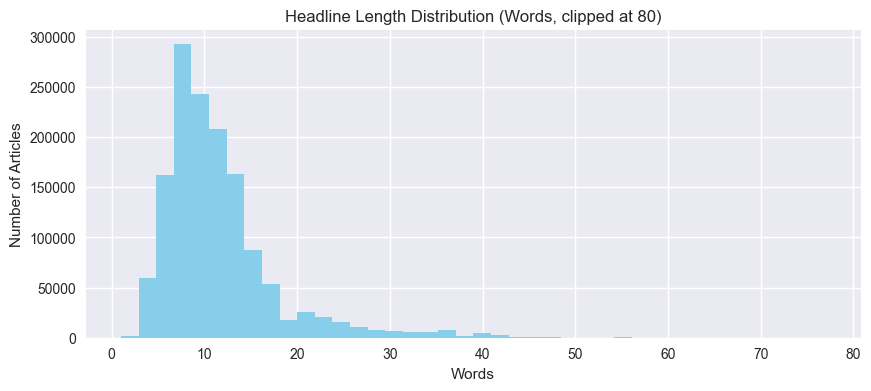


=== Top 20 Publishers by Article Count ===
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Vick Meyer            24826
webmaster             20313
Benzinga_Newsdesk     19410
Zacks                 19390
Jayson Derrick        19050
Allie Wickman         18317
Shanthi Rexaline      16640
Craig Jones           16221
Wayne Duggan          12897
Nelson Hem            12590
Name: count, dtype: int64


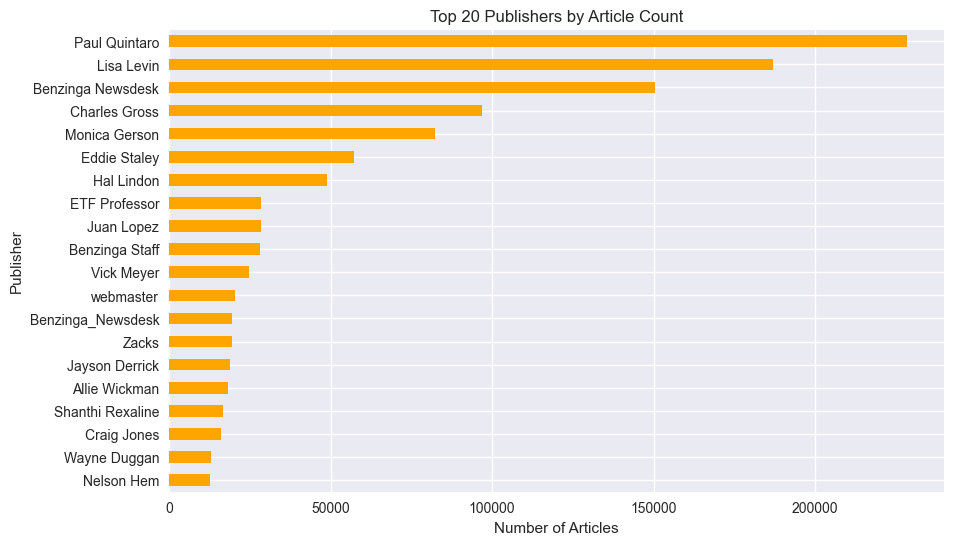

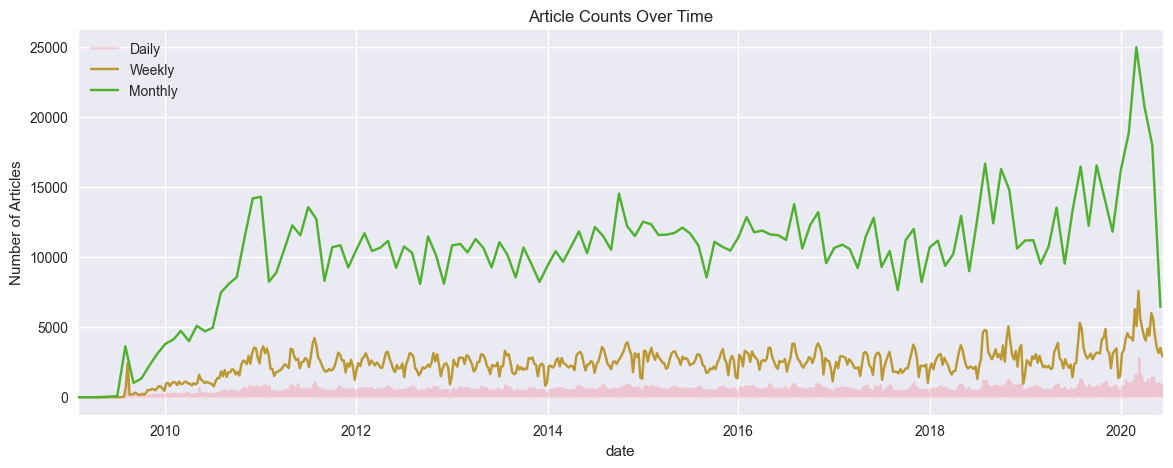


=== Top 10 Days with Highest Article Counts ===
date
2020-03-12 00:00:00+00:00    2739
2020-02-28 00:00:00+00:00    1620
2020-03-19 00:00:00+00:00    1595
2020-02-27 00:00:00+00:00    1567
2020-03-06 00:00:00+00:00    1428
2020-05-07 00:00:00+00:00    1398
2020-03-23 00:00:00+00:00    1391
2020-04-29 00:00:00+00:00    1389
2020-03-11 00:00:00+00:00    1384
2020-04-30 00:00:00+00:00    1327
dtype: int64


In [33]:
# ============================
# DESCRIPTIVE STATISTICS EDA
# ============================

import pandas as pd
import matplotlib.pyplot as plt

# --- 1️⃣ Textual Lengths ---
text_col = 'headline'  # Replace with your column name if different
df['headline_len_chars'] = df[text_col].astype(str).str.len()
df['headline_len_words'] = df[text_col].astype(str).str.split().apply(len)

print("=== HEADLINE LENGTH (CHARACTERS) ===")
print(df['headline_len_chars'].describe())

print("\n=== HEADLINE LENGTH (WORDS) ===")
print(df['headline_len_words'].describe())

plt.figure(figsize=(10,4))
plt.hist(df['headline_len_words'].clip(upper=80), bins=40, color='skyblue')
plt.title("Headline Length Distribution (Words, clipped at 80)")
plt.xlabel("Words")
plt.ylabel("Number of Articles")
plt.show()

# --- 2️⃣ Publisher Activity ---
pub_col = 'publisher'  # Replace if your publisher column is different
df[pub_col] = df[pub_col].fillna('unknown')
publisher_counts = df[pub_col].value_counts()

print("\n=== Top 20 Publishers by Article Count ===")
print(publisher_counts.head(20))

plt.figure(figsize=(10,6))
publisher_counts.head(20).sort_values().plot(kind='barh', color='orange')
plt.title("Top 20 Publishers by Article Count")
plt.xlabel("Number of Articles")
plt.ylabel("Publisher")
plt.show()

# --- 3️⃣ Publication Dates / Trends ---
df['date'] = pd.to_datetime(df['date'], utc=True)
daily_counts = df.set_index('date').resample('D').size()
weekly_counts = df.set_index('date').resample('W').size()
monthly_counts = df.set_index('date').resample('M').size()

plt.figure(figsize=(14,5))
daily_counts.plot(alpha=0.3, label='Daily')
weekly_counts.plot(label='Weekly')
monthly_counts.plot(label='Monthly')
plt.title("Article Counts Over Time")
plt.ylabel("Number of Articles")
plt.legend()
plt.show()

print("\n=== Top 10 Days with Highest Article Counts ===")
print(daily_counts.sort_values(ascending=False).head(10))


In [34]:
# ============================
# TEXT ANALYSIS / TOPIC MODELING
# ============================

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
import re

# --- 1️⃣ Preprocessing ---
text_col = 'headline'  # Replace if your column name differs
corpus = df[text_col].astype(str).fillna('')

# Simple text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

corpus_clean = corpus.apply(clean_text)

# --- 2️⃣ TF-IDF Vectorization (keywords) ---
tfidf = TfidfVectorizer(max_df=0.95, min_df=5, ngram_range=(1,2), stop_words='english', max_features=20000)
X_tfidf = tfidf.fit_transform(corpus_clean)
feature_names_tfidf = np.array(tfidf.get_feature_names_out())

# Top 50 keywords by average TF-IDF
avg_tfidf = np.asarray(X_tfidf.mean(axis=0)).ravel()
top_n = 50
top_idx = avg_tfidf.argsort()[::-1][:top_n]

print("=== Top 50 Keywords / Phrases by Average TF-IDF ===")
for term in feature_names_tfidf[top_idx]:
    print(term)

# --- 3️⃣ Frequent Bigrams/Trigrams ---
vectorizer = CountVectorizer(ngram_range=(2,3), stop_words='english', min_df=5)
X_counts = vectorizer.fit_transform(corpus_clean)
feature_names_counts = vectorizer.get_feature_names_out()
term_counts = np.array(X_counts.sum(axis=0)).ravel()
top_idx_counts = term_counts.argsort()[::-1][:40]

print("\n=== Top 40 Frequent Bigrams / Trigrams ===")
for idx in top_idx_counts:
    print(feature_names_counts[idx], ":", term_counts[idx])

# --- 4️⃣ Topic Modeling with NMF ---
n_topics = 10
nmf = NMF(n_components=n_topics, random_state=42, max_iter=200)
W = nmf.fit_transform(X_tfidf)   # document-topic matrix
H = nmf.components_              # topic-term matrix

# Display top words for each topic
def display_topics(H, feature_names, n_top=12):
    for i, topic in enumerate(H):
        top_features_idx = topic.argsort()[::-1][:n_top]
        top_features = feature_names[top_features_idx]
        print(f"\nTopic {i}: {' | '.join(top_features)}")

print("\n=== NMF Topics ===")
display_topics(H, feature_names_tfidf)

# --- 5️⃣ Assign Dominant Topic to Each Headline ---
df['dominant_topic'] = W.argmax(axis=1)

# Show sample headlines per topic
for t in range(n_topics):
    print(f"\n=== Sample Headlines for Topic {t} ===")
    sample_idx = np.where(df['dominant_topic'] == t)[0][:10]
    for idx in sample_idx:
        print("-", df[text_col].iloc[idx])


=== Top 50 Keywords / Phrases by Average TF-IDF ===
stocks
vs
est
benzingas
eps
earnings
market
reports
shares
update
downgrades
upgrades
52week
sales
pt
buy
announces
session
moving
price
premarket
raises
stocks moving
target
maintains
new
biggest
scheduled
movers
earnings scheduled
trading
price target
benzingas upgrades
says
midday
higher
stock
estimate
yesterday
q4
sees
hit
neutral
watch
bank
q1
etfs
q2
stocks hit
hit 52week

=== Top 40 Frequent Bigrams / Trigrams ===
price target : 47266
stocks moving : 40072
market update : 33089
earnings scheduled : 32055
initiates coverage : 28980
raises pt : 27206
companies trading : 23170
trading higher : 22154
adj eps : 21690
premarket session : 21670
vs est : 21449
benzingas upgrades : 21115
q1 eps : 20704
q2 eps : 20258
q3 eps : 20043
stocks hit : 20030
hit 52week : 19965
stocks hit 52week : 19903
trading lower : 19895
q4 eps : 19846
new 52week : 19070
option alert : 18226
biggest movers : 17795
reports q4 : 17470
reports q2 : 17142
52week

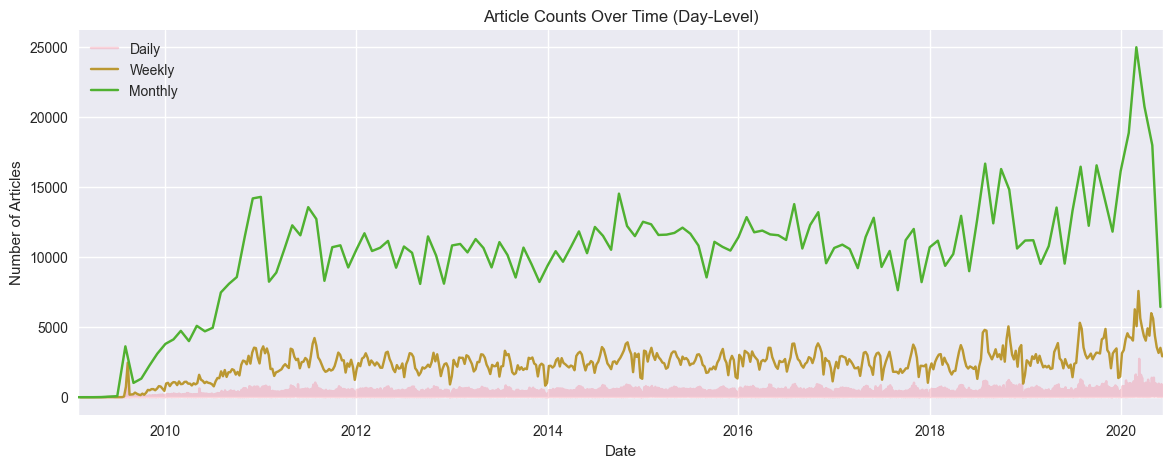

=== Top 10 Days with Highest Article Counts ===
date
2020-03-12 00:00:00+00:00    2739
2020-02-28 00:00:00+00:00    1620
2020-03-19 00:00:00+00:00    1595
2020-02-27 00:00:00+00:00    1567
2020-03-06 00:00:00+00:00    1428
2020-05-07 00:00:00+00:00    1398
2020-03-23 00:00:00+00:00    1391
2020-04-29 00:00:00+00:00    1389
2020-03-11 00:00:00+00:00    1384
2020-04-30 00:00:00+00:00    1327
dtype: int64


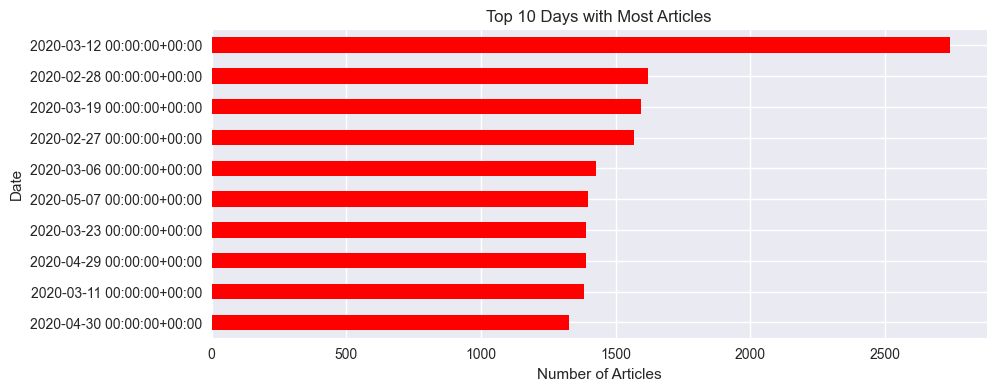

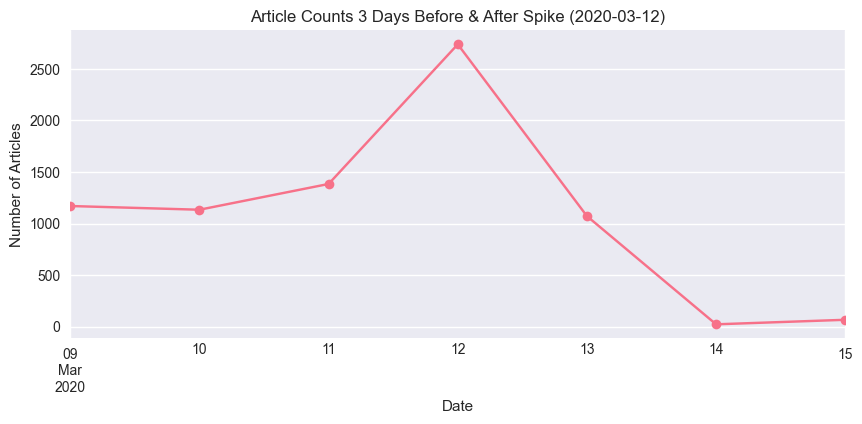

In [38]:
# ============================
# TIME SERIES ANALYSIS (DAY-LEVEL)
# ============================

import matplotlib.pyplot as plt

# Ensure 'date' column is datetime (already cleaned)
df['date'] = pd.to_datetime(df['date'], utc=True)

# --- 1️⃣ Daily / Weekly / Monthly Article Counts ---
daily_counts = df.set_index('date').resample('D').size()
weekly_counts = df.set_index('date').resample('W').size()
monthly_counts = df.set_index('date').resample('M').size()

plt.figure(figsize=(14,5))
daily_counts.plot(alpha=0.3, label='Daily')
weekly_counts.plot(label='Weekly')
monthly_counts.plot(label='Monthly')
plt.title("Article Counts Over Time (Day-Level)")
plt.ylabel("Number of Articles")
plt.xlabel("Date")
plt.legend()
plt.show()

# --- 2️⃣ Top Spike Days ---
top_spikes = daily_counts.sort_values(ascending=False).head(10)
print("=== Top 10 Days with Highest Article Counts ===")
print(top_spikes)

plt.figure(figsize=(10,4))
top_spikes.sort_values().plot(kind='barh', color='red')
plt.title("Top 10 Days with Most Articles")
plt.xlabel("Number of Articles")
plt.ylabel("Date")
plt.show()

# --- 3️⃣ Optional: Trend Around Top Spike ---
top_spike_day = top_spikes.index[0]  # highest spike day
window_start = top_spike_day - pd.Timedelta(days=3)
window_end = top_spike_day + pd.Timedelta(days=3)
window_counts = daily_counts[window_start:window_end]

plt.figure(figsize=(10,4))
window_counts.plot(marker='o', linestyle='-')
plt.title(f"Article Counts 3 Days Before & After Spike ({top_spike_day.date()})")
plt.ylabel("Number of Articles")
plt.xlabel("Date")
plt.show()


=== Top 20 Publishers by Article Count ===
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Vick Meyer            24826
webmaster             20313
Benzinga_Newsdesk     19410
Zacks                 19390
Jayson Derrick        19050
Allie Wickman         18317
Shanthi Rexaline      16640
Craig Jones           16221
Wayne Duggan          12897
Nelson Hem            12590
Name: count, dtype: int64


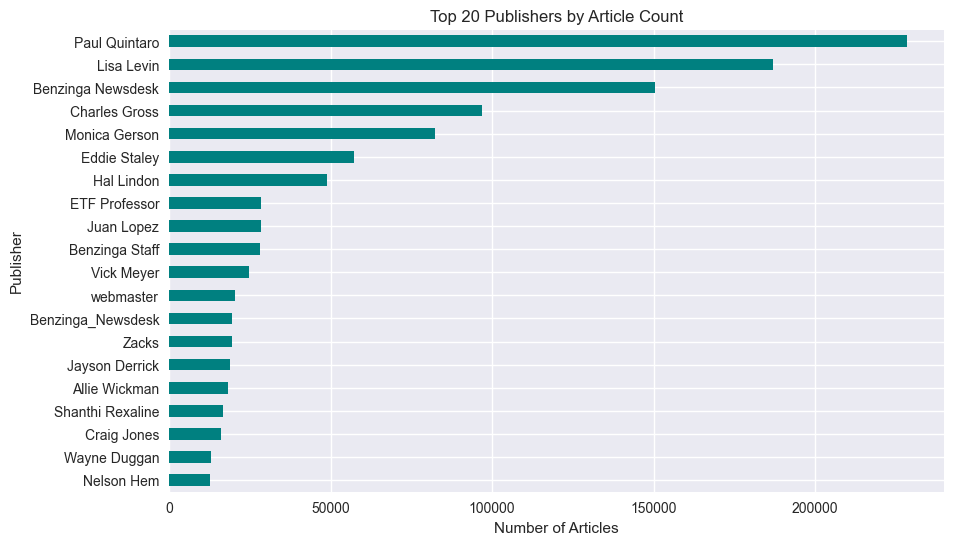


Top words for publisher 'Paul Quintaro':
to         91235
vs         74996
of         72653
eps        56888
reports    55225
in         33297
sales      31046
on         31023
for        28255
from       28230
Name: count, dtype: int64

Top words for publisher 'Lisa Levin':
stocks        68373
for           52323
in            38137
moving        32324
session       32324
top           31264
market        30329
biggest       29090
benzinga's    28342
mid-day       28141
Name: count, dtype: int64

Top words for publisher 'Benzinga Newsdesk':
of         57791
the        51106
to         49415
shares     42366
trading    38800
are        36950
in         32629
up         31786
for        29988
and        28569
Name: count, dtype: int64

Top words for publisher 'Charles Gross':
to        30795
of        25819
for       18821
in        17948
vs        16641
option    15728
alert:    15571
on        13071
@         11479
at         9156
Name: count, dtype: int64

Top words for publisher 'M

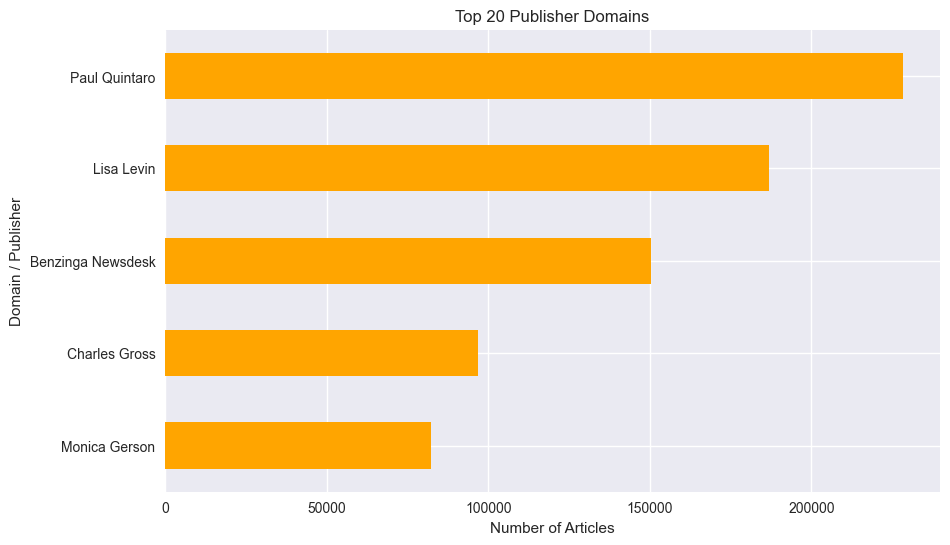

In [40]:
# ============================
# PUBLISHER ANALYSIS
# ============================

import pandas as pd
import matplotlib.pyplot as plt
import re

pub_col = 'publisher'  # replace with your publisher column if different
text_col = 'headline'  # column containing the news headlines

# Fill missing publishers
df[pub_col] = df[pub_col].fillna('unknown')

# --- 1️⃣ Top Publishers by Article Count ---
publisher_counts = df[pub_col].value_counts()
print("=== Top 20 Publishers by Article Count ===")
print(publisher_counts.head(20))

plt.figure(figsize=(10,6))
publisher_counts.head(20).sort_values().plot(kind='barh', color='teal')
plt.title("Top 20 Publishers by Article Count")
plt.xlabel("Number of Articles")
plt.ylabel("Publisher")
plt.show()

# --- 2️⃣ Analyze Type of News per Publisher ---
# Count top keywords per publisher (simple example using first 20 publishers)
top_publishers = publisher_counts.head(20).index
for pub in top_publishers:
    pub_headlines = df[df[pub_col] == pub][text_col].astype(str)
    words = ' '.join(pub_headlines).lower().split()
    word_counts = pd.Series(words).value_counts().head(10)
    print(f"\nTop words for publisher '{pub}':")
    print(word_counts)

# --- 3️⃣ Extract Domains if Publisher is Email ---
# This will extract domain part after '@'
df['publisher_domain'] = df[pub_col].apply(lambda x: x.split('@')[-1] if '@' in x else x)
domain_counts = df['publisher_domain'].value_counts()

print("\n=== Top 5 Publisher Domains ===")
print(domain_counts.head(5))

plt.figure(figsize=(10,6))
domain_counts.head(5).sort_values().plot(kind='barh', color='orange')
plt.title("Top 20 Publisher Domains")
plt.xlabel("Number of Articles")
plt.ylabel("Domain / Publisher")
plt.show()


=== Eye-catching Insights ===
📈 Total articles: 1,407,328
🗓 Year with most articles: 2019, Count: 150,380
🗓 Year with least articles: 2009, Count: 11,489
📅 Month with most articles: 2020-03, Count: 24,995
📅 Month with least articles: 2009-03, Count: 0
🔥 Day with most articles: 2020-03-12, Count: 2,739
❄️ Day with least articles: 2009-02-15, Count: 0
📊 Most active weekday: Thursday, Count: 302,619
📊 Least active weekday: Saturday, Count: 7,759
💡 Articles have increased dramatically over time, showing clear growth in financial news coverage.


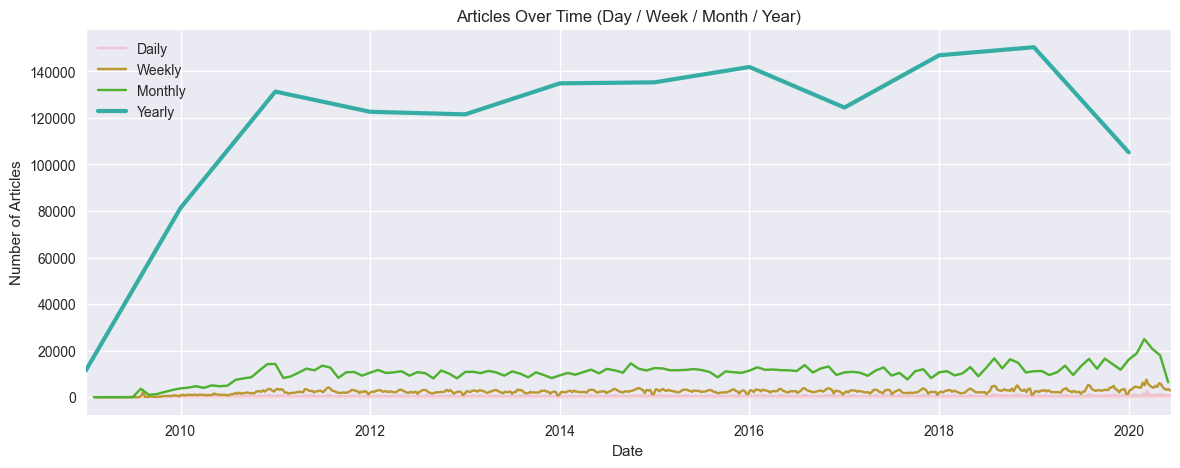

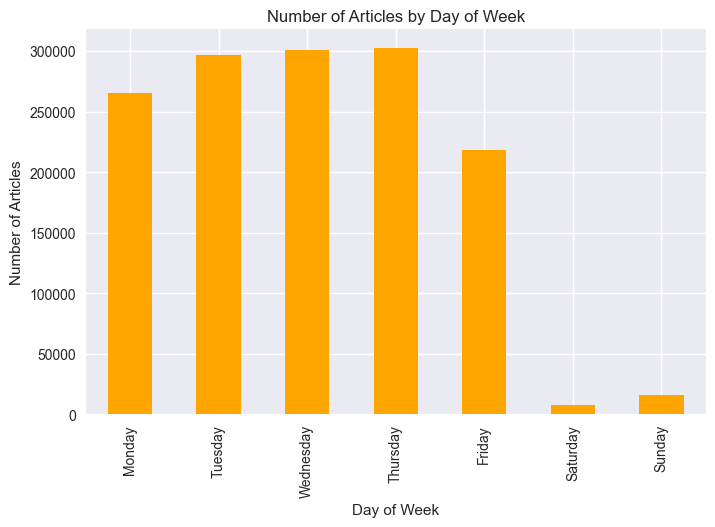

In [44]:
# ============================
# ARTICLES TREND ANALYSIS WITH MOST & LEAST ACTIVE PERIODS
# ============================

import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'date' column is datetime
df['date'] = pd.to_datetime(df['date'], utc=True)
df_indexed = df.set_index('date')

# --- Resample counts ---
articles_per_day = df_indexed.resample('D').size()
articles_per_week = df_indexed.resample('W').size()
articles_per_month = df_indexed.resample('M').size()
articles_per_year = df_indexed.resample('Y').size()

# --- Top / Bottom Spike Days ---
top_spike_day = articles_per_day.idxmax()
top_spike_count = articles_per_day.max()
least_spike_day = articles_per_day.idxmin()
least_spike_count = articles_per_day.min()

# --- Most / Least Active Month ---
most_active_month = articles_per_month.idxmax()
most_active_month_count = articles_per_month.max()
least_active_month = articles_per_month.idxmin()
least_active_month_count = articles_per_month.min()

# --- Most / Least Active Year ---
most_active_year = articles_per_year.idxmax()
most_active_year_count = articles_per_year.max()
least_active_year = articles_per_year.idxmin()
least_active_year_count = articles_per_year.min()

# --- Day of the Week Analysis ---
df['day_of_week'] = df['date'].dt.day_name()
day_counts = df['day_of_week'].value_counts()
most_active_day = day_counts.idxmax()
most_active_day_count = day_counts.max()
least_active_day = day_counts.idxmin()
least_active_day_count = day_counts.min()

# ============================
# NUMERICAL INSIGHTS
# ============================
print("=== Eye-catching Insights ===")
print(f"📈 Total articles: {len(df):,}")
print(f"🗓 Year with most articles: {most_active_year.year}, Count: {most_active_year_count:,}")
print(f"🗓 Year with least articles: {least_active_year.year}, Count: {least_active_year_count:,}")
print(f"📅 Month with most articles: {most_active_month.strftime('%Y-%m')}, Count: {most_active_month_count:,}")
print(f"📅 Month with least articles: {least_active_month.strftime('%Y-%m')}, Count: {least_active_month_count:,}")
print(f"🔥 Day with most articles: {top_spike_day.date()}, Count: {top_spike_count:,}")
print(f"❄️ Day with least articles: {least_spike_day.date()}, Count: {least_spike_count:,}")
print(f"📊 Most active weekday: {most_active_day}, Count: {most_active_day_count:,}")
print(f"📊 Least active weekday: {least_active_day}, Count: {least_active_day_count:,}")
print(f"💡 Articles have increased dramatically over time, showing clear growth in financial news coverage.")

# ============================
# VISUALIZATIONS
# ============================

plt.figure(figsize=(14,5))
articles_per_day.plot(alpha=0.3, label='Daily')
articles_per_week.plot(label='Weekly')
articles_per_month.plot(label='Monthly')
articles_per_year.plot(label='Yearly', linewidth=3)
plt.title("Articles Over Time (Day / Week / Month / Year)")
plt.ylabel("Number of Articles")
plt.xlabel("Date")
plt.legend()
plt.show()

# Day of week visualization
plt.figure(figsize=(8,5))
day_counts.reindex([
    'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'
]).plot(kind='bar', color='orange')
plt.title("Number of Articles by Day of Week")
plt.ylabel("Number of Articles")
plt.xlabel("Day of Week")
plt.show()
